<a href="https://colab.research.google.com/github/yuriborg/time_series/blob/main/ARIMA_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Univariate Time Series

  - Shampoo Sales Dataset

<ipython-input-18-bfda8d6861fe>:7: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv',
<ipython-input-18-bfda8d6861fe>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime('190'+x, '%Y-%m')


Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales, dtype: float64


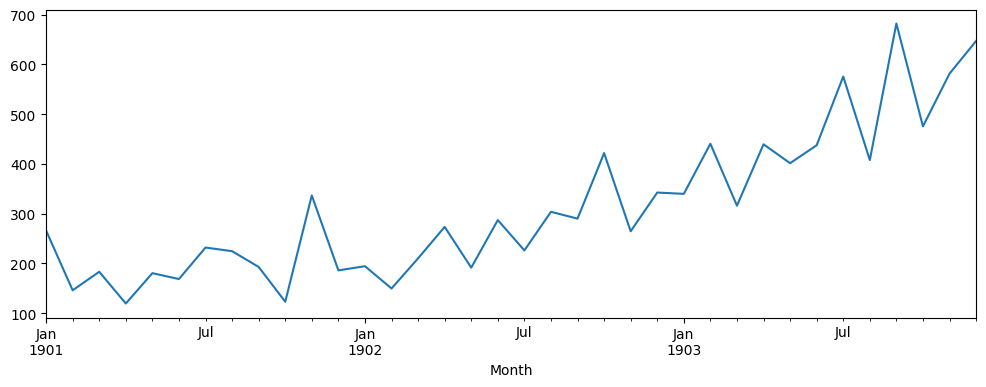

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def parser(x):
  return pd.datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv',
                     header=0,
                     parse_dates=[0],
                     index_col=0,
                     squeeze=True,
                     date_parser=parser
                    )

print(series.head())
series.plot(figsize=(12, 4))
plt.show()

We can see that the Shampoo Sales dataset has a clear trend. This suggests that the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

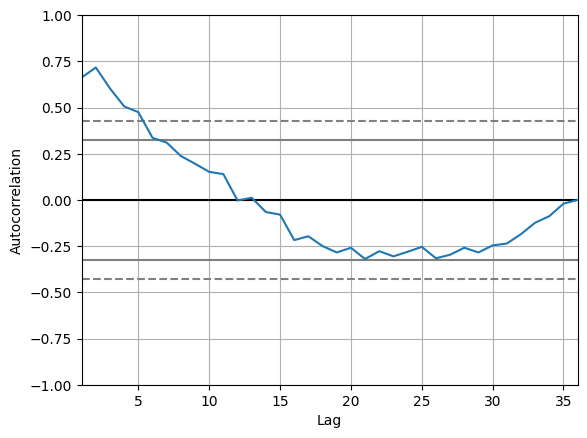

In [19]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

# ARIMA Model

We'll employ the ARIMA(5,1,0) configuration:

  - 5 lags for autoregression (AR)
  - 1st order differencing (I)
  - No moving average term (MA)

In [20]:
# fit an ARIMA model and plot residual errors
from statsmodels.tsa.arima.model import ARIMA

# load dataset
series.index = series.index.to_period('M')

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

#summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Thu, 23 Nov 2023   AIC                            408.969
Time:                        19:24:57   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

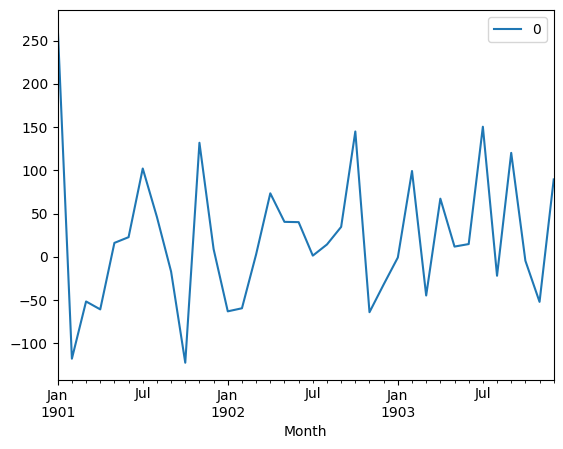

In [22]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

The plot suggests that there may still be some trends not captured by the model

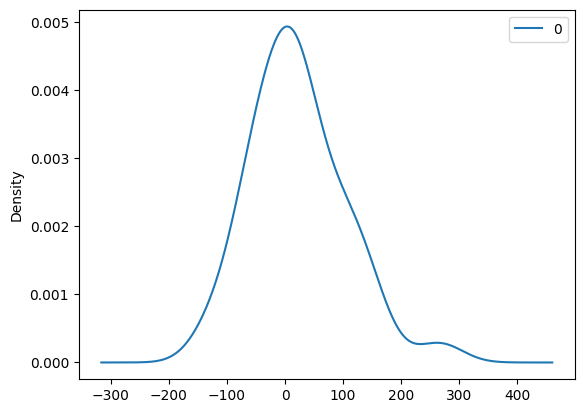

In [24]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()

The density plot of the residual error values, suggests the errors are Gaussian, but may not be centred on zero.

In [25]:
# summary stats of residuals
print(residuals.describe())

                0
count   36.000000
mean    21.936144
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.



In [42]:
model = ARIMA(history, order=(5,1,0))
model_fit = model.fit()
output = model_fit.forecast()
test

array([342.3, 339.7, 440.4, 315.9, 439.3, 401.3, 437.4, 575.5, 407.6,
       682. , 475.3, 581.3, 646.9])

In [26]:
# evaluate an ARIMA model using a walk-forward validation
from sklearn.metrics import mean_squared_error
from math import sqrt

# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(5,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220221, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365674, expected=575.500000
predicted=459.415021, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231275, expected=475.300000
predicted=672.914944, expected=581.300000
predicted=531.541449, expected=646.900000


# Evaluating

Test RMSE: 89.021


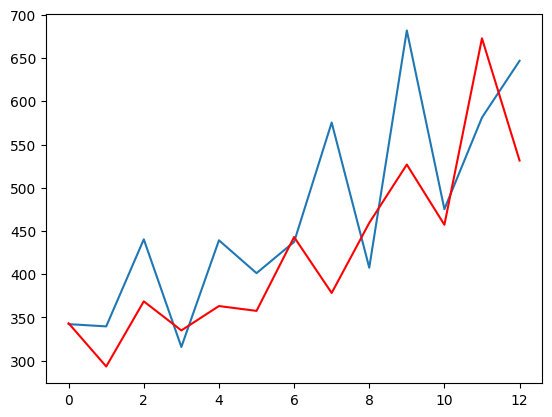

In [27]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()